In [1]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline

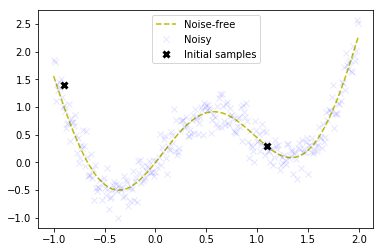

In [11]:
bounds = np.array([[-1.0, 2.0]])
noise = 0.2

def f(X, noise=noise):
    return np.sin(3*X) + X**2 - 0.7*X + noise * np.random.randn(*X.shape)

X_init = np.array(([-0.9], [1.1]))
Y_init = f(X_init)


# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
Y = f(X,0)


plt.plot(X, Y, 'y--')
plt.plot(X, f(X), 'bx', alpha=0.1)
plt.plot(X_init, Y_init, 'kx', mew=3)
plt.legend(['Noise-free', 'Noisy', 'Initial samples'])
plt.show()

**Goal:** *Find the global optimum on the left in a small number of steps.*

### Acquisition function
**Expected Improvement**

In [12]:
def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    # Computes the EI at points X based on existing samples X_sample 
    # and Y_sample using Gaussian process surrogate model
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)
    
    sigma = sigma.reshape(-1, X_sample.shape[1])
    
    mu_sample_opt = np.max(mu_sample)
    
    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    
    return ei

**Function to select next location**

In [13]:
def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    # Proposes the next sampling point by optimizing the acquisition function
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquistion function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)
    
    # Find the best optimum by starting from n_restart different random points
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='l-BFGS-B')
        if res.fun < min_val:
            min_val = res.fun[0]
            min_x = res.x
            
        return min_x.reshape(-1, 1)

## Improve current X

In [16]:
def improveX(X):
    learning_rate = 0.1
    X_next = X - learning_rate * (3*np.cos(3*X) + 2*X - 0.7)
    return X_next

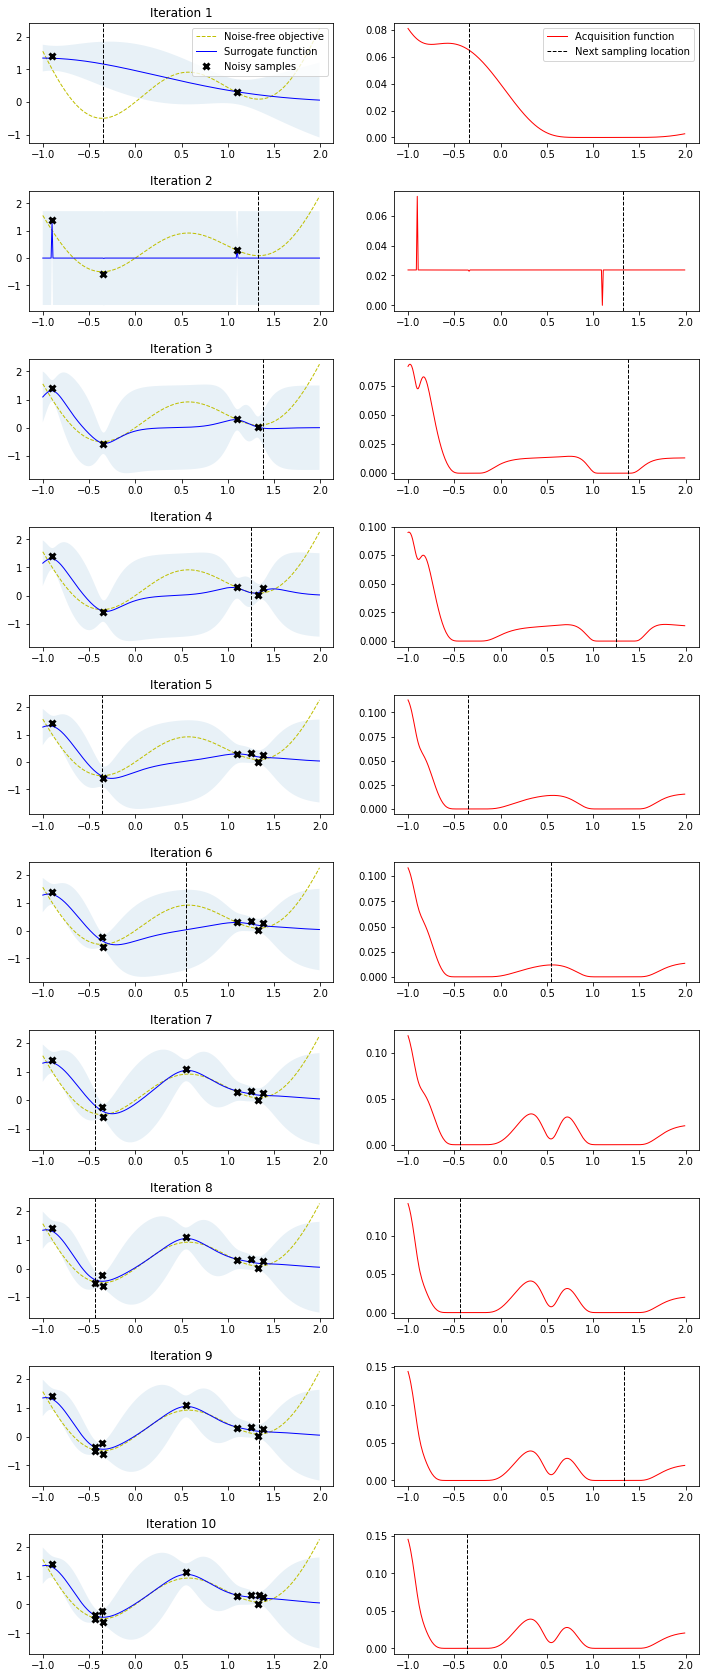

In [18]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
from bayesian_optimization_util import plot_approximation, plot_acquisition

# Gaussian process with Matérn kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 10

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
    
    # Apply algorithm here
    X_next = improveX(X_next)
    
    # Obtain next noisy sample from the objective function
    Y_next = f(X_next, noise)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title('Iteration '+str(i+1))

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample, Y_sample, gpr), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))
plt.show()